In [1]:
import cobra 
from SimulateIntNets import IntSigMet
from cobra.io import read_sbml_model 
from InsGluSig_GluMet.InsGluSignalModel import InsGluSignal
from InsGluSig_GluMet.FracActInsGluSig import FracActInsGluSig
import numpy as np
import matplotlib.pyplot as plt

## Metabolic network

In [2]:
# loading the metabolic model
model = read_sbml_model('./InsGluSig_GluMet/GlucoseMetCBModel.xml')
# objective function
Obj = ['PFK','FBP']

No objective in listOfObjectives
No objective coefficients in model. Unclear what should be optimized


## Signalling network

In [9]:
# External inputs
AAm = 0.25 # Amino acid
FF =  0.68 # Fatty acid
Gpi = 3.3  # Glucose Conc in mM (1mM = 18mg/dl)

ext_inp = np.array([Gpi,FF,AAm])

In [10]:
# Initial conditions for the ODE model
b_InsL = 4.4*2
b_InsP = 1.25*2
b_InsV = 7.5
Glnp_0 = 25e-12   
Glcn_0 = 1         
FR_0   = 26480    
RS_0   = 22760*1        
LR_0   = 10   
LRS_0  = 68280  
LRP_0  = 8970            
DAG_0  = 1
PKA_0  = 8e-6
cAMP_0 = 10**(-5.5)
PDE3a_0= 1.0
AMPK_0 = 0.2 

# Initial conditions
init = [10,0,10,0,10,0,10,0,10,0,10,0,10,0,10,0,b_InsV,b_InsL,b_InsP,Glnp_0,
        Glcn_0,FR_0,RS_0,LR_0,LRS_0,LRP_0,DAG_0,PKA_0,cAMP_0,PDE3a_0,AMPK_0] 

## Integrated network parameters

In [11]:
# Time step and Total time of simulation
dt = 1
T = 200

# Beta value
beta = np.array([0.009])

# Exchange reaction to external input mapping
all_rxn_ids = np.array([i.id for i in model.reactions])
Sm = {'input_ids':0,'rxn_ids':np.where(all_rxn_ids=='sink_glc_D[e]')[0][0]} # Glucose exchange (Metabolic network) is mapped to glucose metabolite conc. (Signalling network) 

# Enzyme to signalling molecule mapping
Se = {} # There is no enzyme that is also a signalling molecule

# Reactions regualted by the signalling network
SigToReac = np.zeros((3,len(model.reactions)))

# reactions regulated by signalling molecules
rxn_ids = ['GLCt1','GLGNS1','PYK','HEX1','PFK','FBP','PEPCK','PEPCKm','G6PPer','GLPASE1']
all_rxn_ids_idx_map = {i.id:j for j,i in enumerate(model.reactions)}
rxn_idx = [all_rxn_ids_idx_map[i] for i in rxn_ids]

signal_signs=np.array([[0,0,1],[1,-1,0],[1,-1,0],[1,0,0],[1,-1,0],[-1,1,0],[-1,1,0],[-1,1,0],[0,1,0]
                       ,[0,1,0]])
for i in range(len(rxn_idx)):
    SigToReac[:,rxn_idx[i]]=signal_signs[i]

# whether to use FVA or FBA
FVA=1

# whether to use MAX or Average for multiple signals effecting a reaction
MAX=0

## Integrated network simulation

In [12]:
concInt, F_reactions, concUnint, F, fracInt, lbnew, ubnew, ext_inp= IntSigMet(model,Obj,InsGluSignal,ext_inp,init,dt,T,FracActInsGluSig,beta,Se,Sm,SigToReac,FVA,MAX)

 Progress: 100%|**************************************************************|

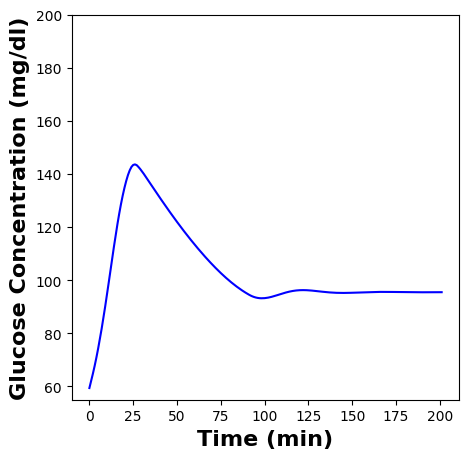

In [13]:
# plotting the change in glucose concentration
Glu_conc = np.array(ext_inp)[:,0]
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(np.arange(0,T+2*dt,dt),Glu_conc*18,c='b',linewidth=1.5)
ax.set_xlabel('Time (min)',fontweight='bold',fontsize=16);
ax.set_ylabel('Glucose Concentration (mg/dl)',fontweight='bold',fontsize=16)
ax.set_ylim([55,200]);